Author: Tyler Chase

Date: 2017/05/18

# Subreddit Classification

This code uses a classification model to classify an image to one of 20 subreddits. For the sake of the milestone we implement an Alex Net model and analyze the results. 

## Load Datasets

In [7]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train labels shape: ', data.y_train.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation labels shape: ', data.y_val.shape)
print('Test data shape: ', data.X_test.shape)
print('Test labels shape: ', data.y_test.shape)


Train data shape:  (25450, 128, 128, 3)
Train labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test labels shape:  (3182,)


## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 1792
* ReLU activation
* affine layer from 1792 to 1792
* ReLU activation
* affine layer from 1792 to 20

In [9]:
class AlexNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
  
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.X_placeholder, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') 
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training_placeholder)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training_placeholder)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')   
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')  
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        aff1 = tf.layers.dense(mp_flat, 1792)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 1792)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.class_size)
    
        return y_out        

## Train the Model

In [1]:
# Create model instance
tf.reset_default_graph()

model_config = ModelConfig(learning_rate=0.003)
train_config = TrainConfig(num_epochs=2, minibatch_size=100, print_every=100, \
    saver_address=r'/home/tylerchase/CS-231N-Final-Project/src/subreddit_classification_parameters/')
model = AlexNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

NameError: name 'tf' is not defined

## Return Loss and Accuracy History

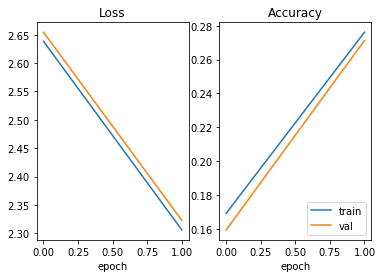

In [16]:
# Plot Loss and Accuracy
model.plot_loss_acc(data)

## Test Loading the Model

In [17]:
# Reset Graph
tf.reset_default_graph()
loader_address=r'../subreddit_classification_parameters/classification_model'

# Create model instance
model_config = ModelConfig(learning_rate=0.003)
train_config = TrainConfig(num_epochs=2, minibatch_size=100, print_every=100, \
    saver_address=r'/home/tylerchase/CS-231N-Final-Project/src/subreddit_classification_parameters/')
model = AlexNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, loader_address) 

# Test Model Accuracy
loss_train, acc_train = model.train_batch(data, session, train_config)
variables = [model.cost, model.accuracy]
loss_val, acc_val = session.run(variables, \
    {model.X_placeholder:data.X_val, model.y_placeholder:data.y_val, model.is_training_placeholder:False})

print('Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format((100*acc_train), (100*acc_val)))

Training Accuracy 27.6%, Vallidation Accuracy:27.1%


## Output Predictions for Validation 

In [18]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, model.y_placeholder: data.y_val, 
                                            model.is_training_placeholder:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for Subreddit Classification

Normalized confusion matrix


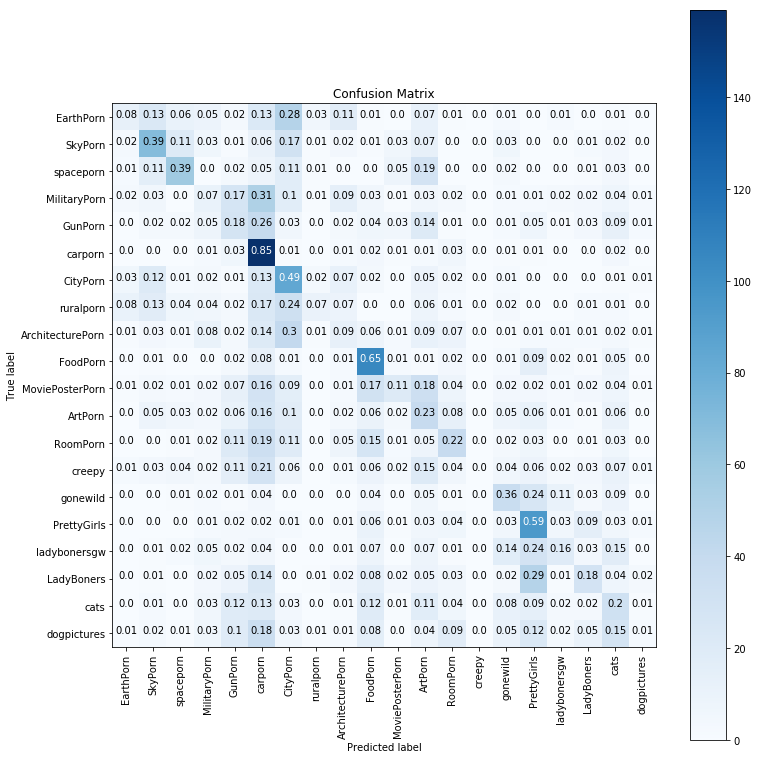

In [20]:
# Code to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          save_address = ''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.savefig(save_address + 'confusion_mat.png')

classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_val, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True)
